##Imports


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import sys

# Add the src directory to the system path
src_path = '/content/drive/MyDrive/Signature_Project/src'
if src_path not in sys.path:
    sys.path.append(src_path)

from preprocess import preprocess_image
from features import extract_features

Mounted at /content/drive


##Paths

In [ ]:
DATA_DIR = os.path.join('/content/drive/MyDrive/Signature_Project/data', "signatures")
GENUINE_DIR = os.path.join(DATA_DIR, "full_forg")
FORGED_DIR = os.path.join(DATA_DIR, "full_org")

def load_dataset():
    X, y = [], []
    for path, label in [(GENUINE_DIR, 1), (FORGED_DIR, 0)]:
        for f in os.listdir(path):
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                X.append(os.path.join(path, f))
                y.append(label)
    return X, np.array(y)

image_paths, labels = load_dataset()
print(f"Loaded {len(image_paths)} images (genuine={np.sum(labels == 1)}, forged={np.sum(labels == 0)})")

Loaded 2640 images (genuine=1320, forged=1320)


##Load images and labels

In [ ]:
def load_dataset():
    X, y = [], []
    for path, label in [(GENUINE_DIR, 1), (FORGED_DIR, 0)]:
        for f in os.listdir(path):
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                X.append(os.path.join(path, f))
                y.append(label)
    return X, np.array(y)

image_paths, labels = load_dataset()

##Preprocess and extract features

In [ ]:
features = []
for path in image_paths:
    img = preprocess_image(path)
    feat = extract_features(img)
    features.append(feat)

X = np.array(features)
y = labels

print(f"Feature matrix shape: {X.shape}")

Feature matrix shape: (2640, 3795)


##EDA

✅ Dataset loaded for EDA
Shape: (700, 3796)
label
0.759869    700
Name: count, dtype: int64


/tmp/ipython-input-2939170140.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


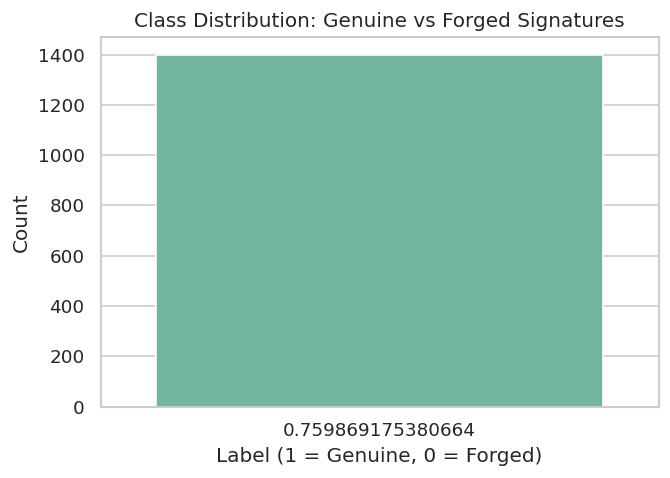


📊 Basic Statistical Summary:


,count,mean,std,min,25%,50%,75%,max
0,700.0,2629.775635,808.299988,895.000000,2073.250000,2570.500000,3094.250000,5354.000000
1,700.0,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000
2,700.0,0.121474,0.040493,0.050062,0.090996,0.114805,0.149929,0.268769
3,700.0,0.456198,0.042688,0.297343,0.428321,0.460915,0.485893,0.563384
4,700.0,0.493859,0.055862,0.285549,0.463426,0.496640,0.524319,0.703887
5,700.0,0.008115,0.057474,0.000000,0.000000,0.000000,0.000000,0.637682
6,700.0,0.004383,0.033537,0.000000,0.000000,0.000000,0.000000,0.360098
7,700.0,0.007529,0.048298,0.000000,0.000000,0.000000,0.000000,0.528741
8,700.0,0.002061,0.019419,0.000000,0.000000,0.000000,0.000000,0.361029
9,700.0,0.004481,0.034303,0.000000,0.000000,0.000000,0.000000,0.582606


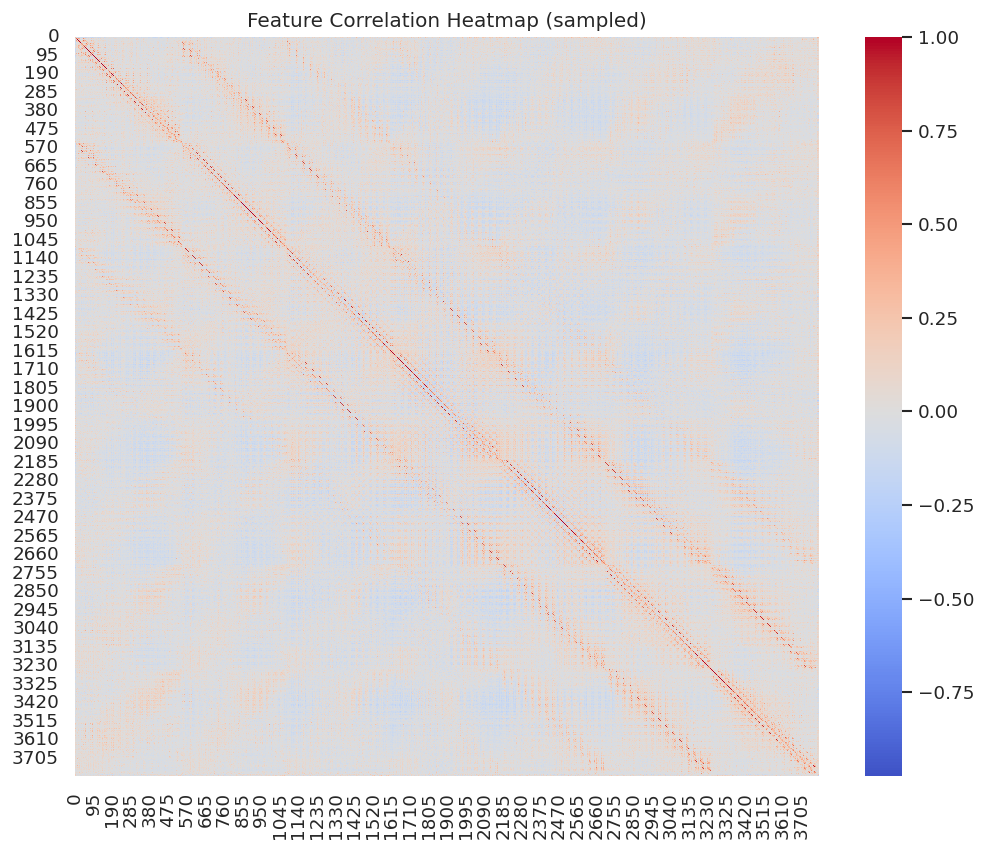

Performing PCA for 2D visualization...


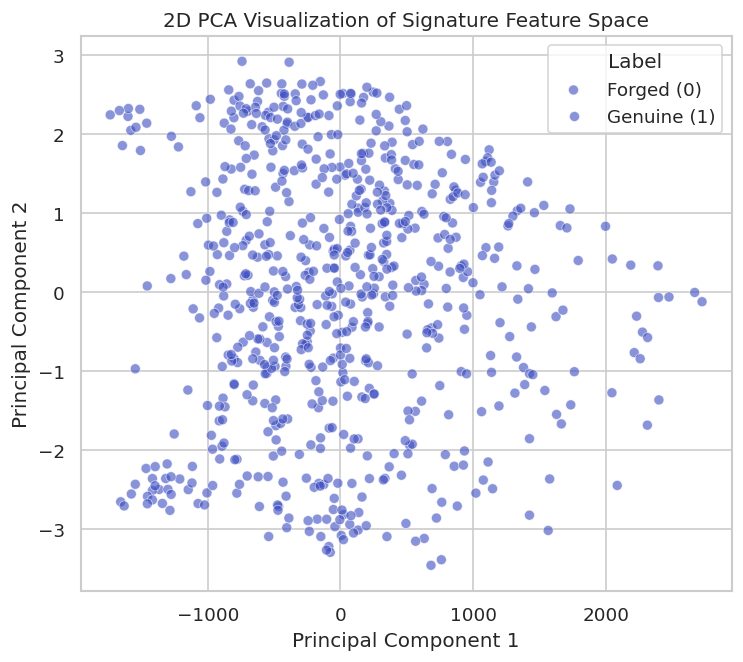

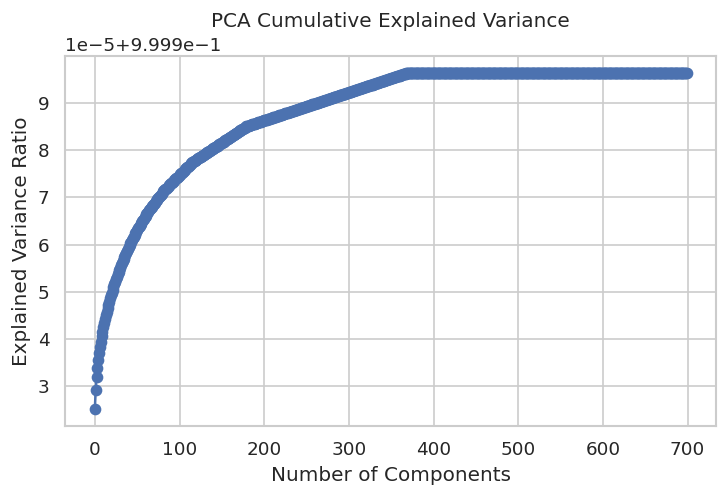

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Convert feature matrix and labels into a DataFrame
df = pd.DataFrame(X)
df['label'] = y

print("Dataset loaded for EDA")
print("Shape:", df.shape)
print(df['label'].value_counts())

# Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title("Class Distribution: Genuine vs Forged Signatures")
plt.xlabel("Label (1 = Genuine, 0 = Forged)")
plt.ylabel("Count")
plt.show()

# Feature Statistics Overview
print("\nBasic Statistical Summary:")
display(df.describe().T.head(10))

# Correlation Heatmap (sampled for speed)
sample_df = df.sample(min(1000, len(df)), random_state=42)
corr = sample_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap (sampled)")
plt.show()

# PCA Visualization (2D)
print("Performing PCA for 2D visualization...")
pca_vis = PCA(n_components=2)
X_pca = pca_vis.fit_transform(X)

plt.figure(figsize=(7,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, alpha=0.6, palette='coolwarm')
plt.title("2D PCA Visualization of Signature Feature Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Label", labels=["Forged (0)", "Genuine (1)"])
plt.show()

# PCA Explained Variance (how many components matter)
pca_full = PCA().fit(X)

plt.figure(figsize=(7,4))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.title("PCA Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()


##train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (2112, 3795)
Testing data shape: (528, 3795)


##Pipelines



Training LogisticRegression...
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       264
           1       0.79      0.78      0.78       264

    accuracy                           0.79       528
   macro avg       0.79      0.79      0.79       528
weighted avg       0.79      0.79      0.79       528

AUC: 0.8796


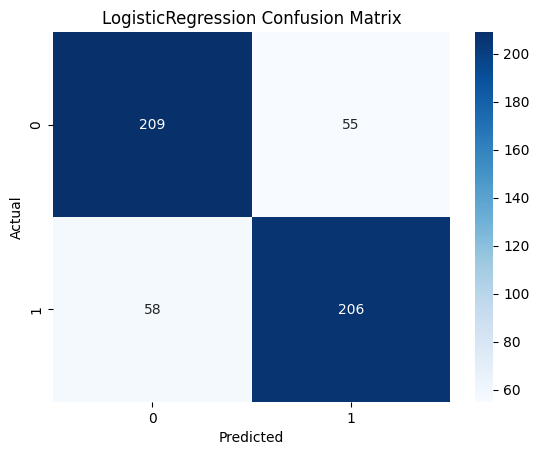


Training SVM...
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       264
           1       0.93      0.88      0.91       264

    accuracy                           0.91       528
   macro avg       0.91      0.91      0.91       528
weighted avg       0.91      0.91      0.91       528

AUC: 0.9701


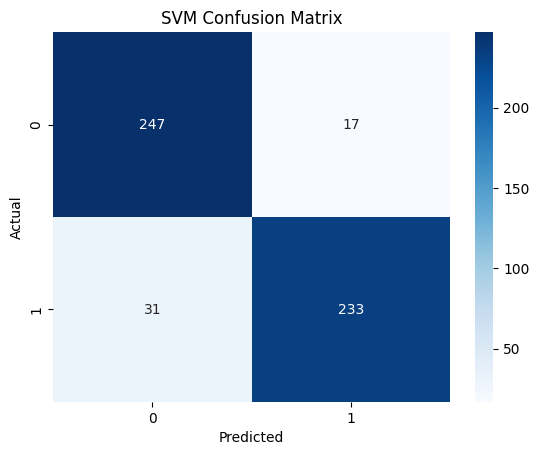


Training DecisionTree...
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       264
           1       0.68      0.67      0.67       264

    accuracy                           0.68       528
   macro avg       0.68      0.68      0.68       528
weighted avg       0.68      0.68      0.68       528

AUC: 0.6675


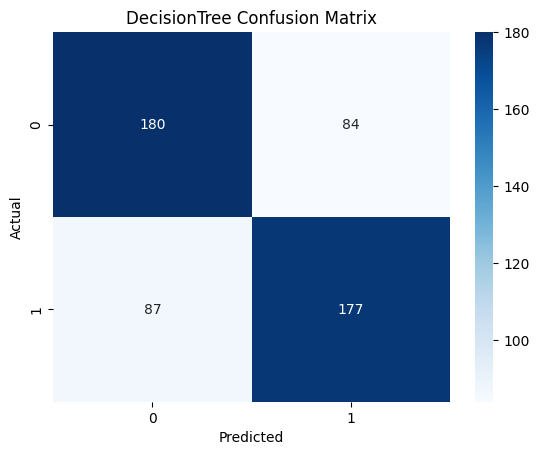


Training SGDClassifier...
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       264
           1       0.80      0.81      0.81       264

    accuracy                           0.80       528
   macro avg       0.80      0.80      0.80       528
weighted avg       0.80      0.80      0.80       528

AUC: 0.8376


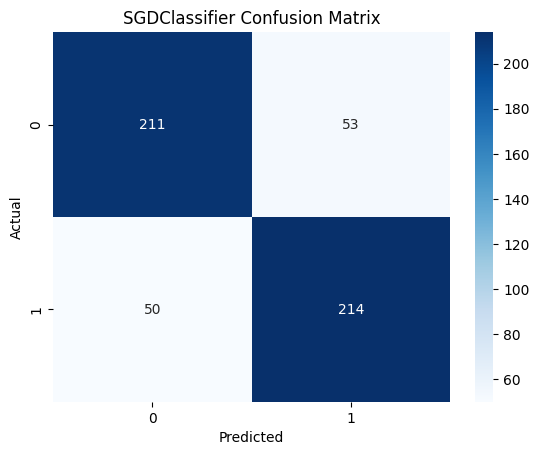

Equal Error Rate (EER) for the best model (SVM): 9.85%


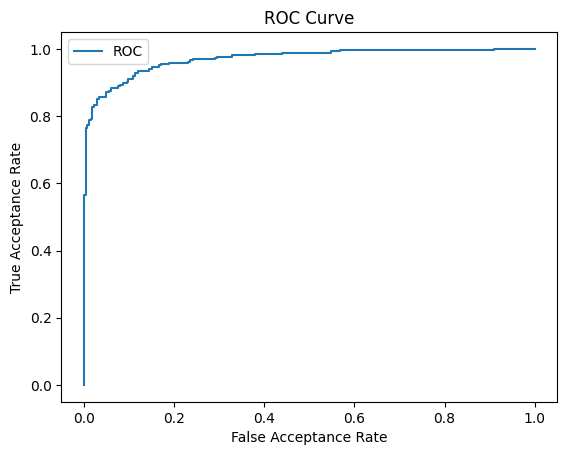

Model saved at ../models/best_signature_model.joblib


In [ ]:
# Define pipelines
def make_pipeline(model):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('clf', model)
    ])

models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "SVM": SVC(kernel='rbf', probability=True, class_weight='balanced'),
    "DecisionTree": DecisionTreeClassifier(max_depth=10, class_weight='balanced'),
    "SGDClassifier": SGDClassifier(loss='log_loss', max_iter=1000, class_weight='balanced')
}

# Train and evaluate
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    pipe = make_pipeline(model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None

    print(classification_report(y_test, y_pred))
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    print(f"AUC: {auc:.4f}" if auc else "No probability output for AUC.")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

    results[name] = {"model": pipe, "AUC": auc}

# Compute FAR / FRR / EER (for best model)
best_model_name = max(results.items(), key=lambda kv: kv[1]["AUC"] if kv[1]["AUC"] else 0)[0]
best_model = results[best_model_name]["model"]
y_score = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thr = roc_curve(y_test, y_score)
FAR = fpr
FRR = 1 - tpr
eer_index = np.argmin(np.abs(FAR - FRR))
EER = (FAR[eer_index] + FRR[eer_index]) / 2
print(f"Equal Error Rate (EER) for the best model ({best_model_name}): {EER*100:.2f}%")

plt.plot(FAR, 1-FRR, label='ROC')
plt.xlabel('False Acceptance Rate')
plt.ylabel('True Acceptance Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Save model
os.makedirs("../models", exist_ok=True)
joblib.dump(best_model, "../models/best_signature_model.joblib")
print("Model saved at ../models/best_signature_model.joblib")

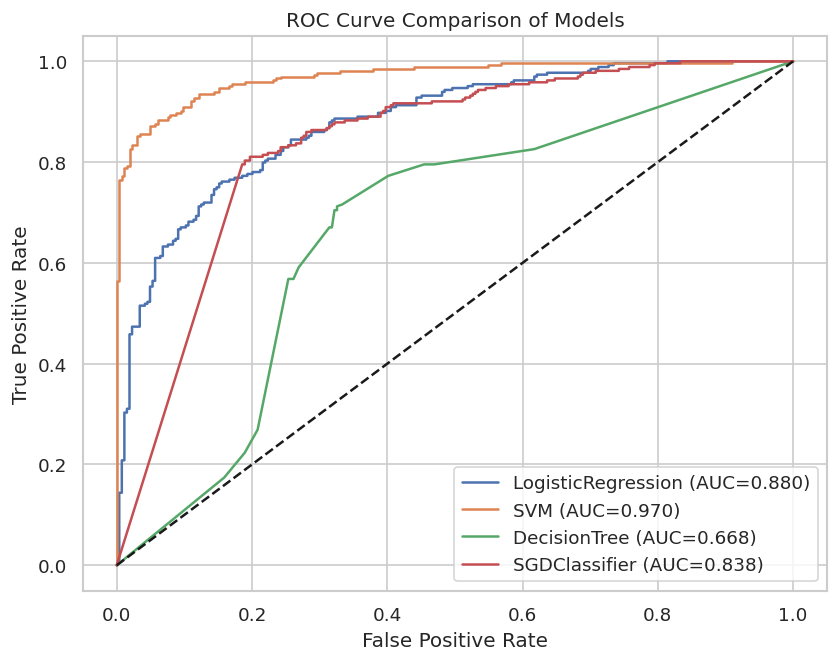

,Accuracy,Precision,Recall,F1-Score,AUC
Model,,,,,
LogisticRegression,0.786,0.789,0.780,0.785,0.880
SVM,0.909,0.932,0.883,0.907,0.970
DecisionTree,0.676,0.678,0.670,0.674,0.668
SGDClassifier,0.805,0.801,0.811,0.806,0.838


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

# Collect metrics for each trained model
metrics_summary = []

plt.figure(figsize=(8,6))
for name, info in results.items():
    model = info["model"]

    # Predictions & probabilities
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = None

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    metrics_summary.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "AUC": auc
    })

    # Plot ROC curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of Models")
plt.legend()
plt.grid(True)
plt.show()

# --- Create and display metrics table ---
df_metrics = pd.DataFrame(metrics_summary)
df_metrics.set_index("Model", inplace=True)
display(df_metrics.style.format({
    "Accuracy": "{:.3f}",
    "Precision": "{:.3f}",
    "Recall": "{:.3f}",
    "F1-Score": "{:.3f}",
    "AUC": "{:.3f}"
}).background_gradient(cmap="Blues"))

## Imports and Setup

## Data Loading and Preprocessing

In [ ]:
from google.colab import files
model_path = '/models/best_signature_model.joblib'
files.download(model_path)
print(f"Download link generated for {model_path}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download link generated for /models/best_signature_model.joblib


In [ ]:
from google.colab import files
model_path = '../models/best_signature_model.joblib' # Note the correct path
files.download(model_path)
print(f"Download link generated for {model_path}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download link generated for ../models/best_signature_model.joblib
